# Image Classification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate
import re

In [3]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Download data

Press <kbd>Ctrl</kbd><kbd>Shift</kbd><kbd>J</kbd> in Windows/Linux and <kbd>Cmd</kbd><kbd>Opt</kbd><kbd>J</kbd> in Mac, and a small window the javascript 'Console' will appear.

Getting the urls of each of the images by running the following commands:

```javascript
urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

In [4]:
folder = 'cats/'
file = 'cats.csv'

In [5]:
folder = 'dogs/'
file = 'dogs.csv'

### Run per each category

In [7]:
path = Path('data/')
dest=path/folder
dest.mkdir(parents=True, exist_ok=True)

download_images(file, dest)

In [8]:
verify_images(dest, delete=True, max_size=500)

cannot identify image file <_io.BufferedReader name='data/dogs/00000221.svg'>
cannot identify image file <_io.BufferedReader name='data/dogs/00000087.jpg'>
cannot identify image file <_io.BufferedReader name='data/dogs/00000285.jpg'>
cannot identify image file <_io.BufferedReader name='data/dogs/00000093.jpg'>
cannot identify image file <_io.BufferedReader name='data/dogs/00000179.jpeg'>


/data/anaconda/envs/fastai/lib/python3.6/site-packages/PIL/Image.py:969: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


cannot identify image file <_io.BufferedReader name='data/dogs/00000178.jpg'>


/data/anaconda/envs/fastai/lib/python3.6/site-packages/PIL/Image.py:969: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


cannot identify image file <_io.BufferedReader name='data/dogs/00000190.jpg'>
cannot identify image file <_io.BufferedReader name='data/dogs/00000010.jpg'>
cannot identify image file <_io.BufferedReader name='data/dogs/00000229.jpg'>


## Looking at the data

In [10]:
# fnames = get_image_files(path_img)
# fnames[:5]

In [11]:
# # extracting classes from file names
# np.random.seed(2)
# pat = r'/([^/]+)_\d+.jpg$'
# re.findall(pat,fnames[4].as_posix())

In [9]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

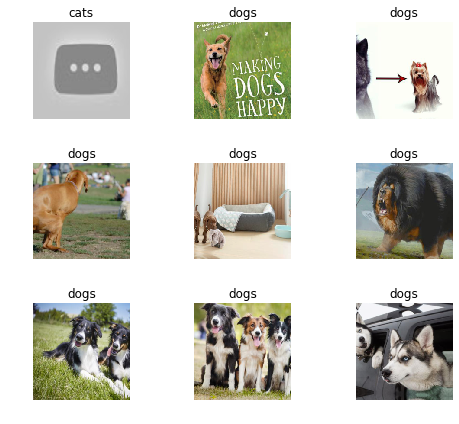

In [12]:
data.show_batch(rows=3, figsize=(7,6))

In [13]:
print(data.classes)
len(data.classes),data.c

['cats', 'dogs']


(2, 2)

## Training: resnet34

We will train for 4 epochs (4 cycles through all our data).

In [14]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [15]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
1,0.690860,0.163617,0.034091,00:10
2,0.409153,0.093087,0.045455,00:04
3,0.284239,0.086525,0.034091,00:04
4,0.225808,0.079979,0.022727,00:04


In [16]:
learn.save('stage-1')

## Results of stage 1

In [17]:
interp = ClassificationInterpretation.from_learner(learn)


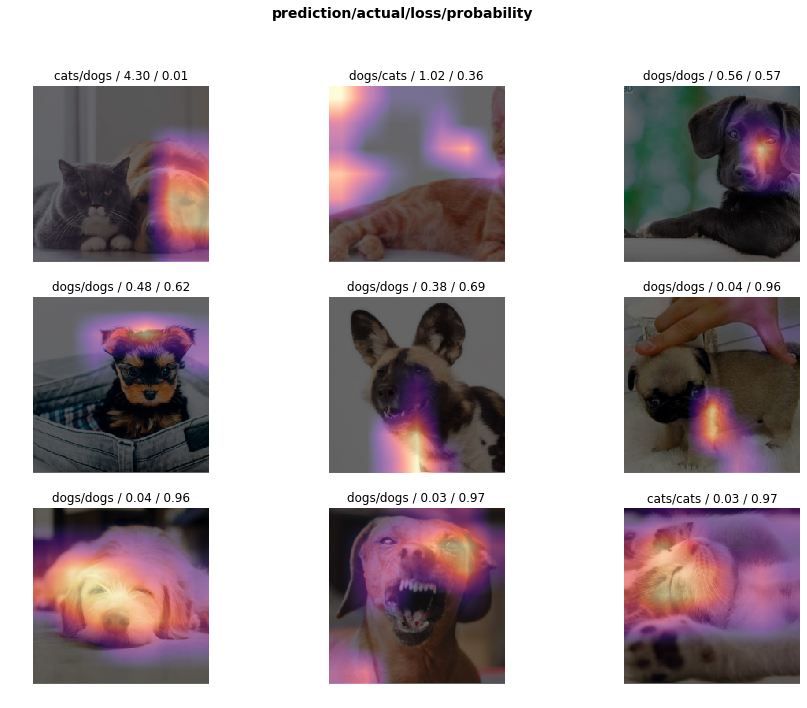

In [18]:
#top losses
interp.plot_top_losses(9, figsize=(15,11))

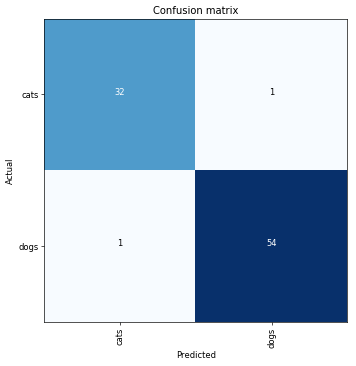

In [20]:
#confusion matrix
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [23]:
interp.most_confused(min_val=0)

[('cats', 'dogs', 1),
 ('dogs', 'cats', 1),
 ('cats', 'cats', 0),
 ('dogs', 'dogs', 0)]

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [29]:
#learn.unfreeze()

In [30]:
#learn.fit_one_cycle(1)

In [28]:
learn.load('stage-1');

In [31]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


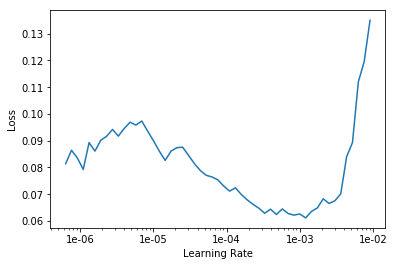

In [32]:
learn.recorder.plot()

In [33]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-05,1e-04))

epoch,train_loss,valid_loss,error_rate,time
1,0.074018,0.087478,0.034091,00:05
2,0.112313,0.070526,0.022727,00:05
3,0.080300,0.063845,0.011364,00:05
4,0.067496,0.063257,0.011364,00:05


That's a pretty accurate model!

In [34]:
learn.save('stage-2')

## Results of stage 2

In [36]:
learn.load('stage-2');

In [37]:
interp = ClassificationInterpretation.from_learner(learn)


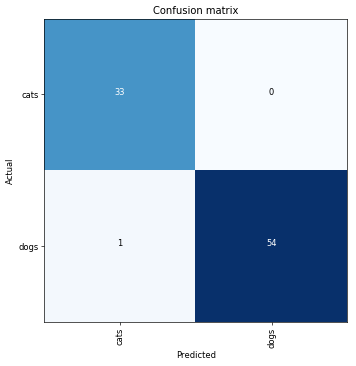

In [38]:
#confusion matrix
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

## Cleaning Up

Some of our top losses aren't due to bad performance by our model. There are images in our data set that shouldn't be.

Using the `ImageCleaner` widget from `fastai.widgets` we can prune our top losses, removing photos that don't belong.

First we need to get the file paths from our top_losses. We can do this with `.from_toplosses`. We then feed the top losses indexes and corresponding dataset to `ImageCleaner`.

Notice that the widget will not delete images directly from disk but it will create a new csv file `cleaned.csv` from where you can create a new ImageDataBunch with the corrected labels to continue training your model.

In [40]:
#!conda install -y -c ipywidgets

In [41]:
from fastai.widgets import *

In [42]:
ds, idxs = DatasetFormatter().from_toplosses(learn, ds_type=DatasetType.Valid)

Flag photos for deletion by clicking 'Delete'. Then click 'Next Batch' to delete flagged photos and keep the rest in that row. `ImageCleaner` will show you a new row of images until there are no more to show. In this case, the widget will show you images until there are none left from `top_losses.ImageCleaner(ds, idxs)`

In [43]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

You can also find duplicates in your dataset and delete them! To do this, you need to run `.from_similars` to get the potential duplicates' ids and then run `ImageCleaner` with `duplicates=True`. The API works in a similar way as with misclassified images: just choose the ones you want to delete and click 'Next Batch' until there are no more images left.

In [44]:
ds, idxs = DatasetFormatter().from_similars(learn, ds_type=DatasetType.Valid)

Getting activations...


Computing similarities...


In [45]:
ImageCleaner(ds, idxs, path, duplicates=True)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

Remember to recreate your ImageDataBunch from your `cleaned.csv` to include the changes you made in your data!

## Deploying the model

This will create a file named 'export.pkl' in the directory where we were working that contains everything we need to deploy our model 

In [46]:
learn.export()

In [47]:
defaults.device = torch.device('cpu')

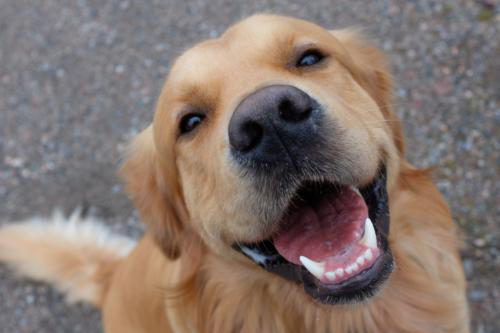

In [48]:
img = open_image('data/dogs/00000008.jpeg')
img

In [50]:
learn = load_learner(path)

In [52]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class.obj

'dogs'

In [53]:
outputs

tensor([0.0038, 0.9962])


```python
@app.route("/classify-url", methods=["GET"])
async def classify_url(request):
    bytes = await get_bytes(request.query_params["url"])
    img = open_image(BytesIO(bytes))
    _,_,losses = learner.predict(img)
    return JSONResponse({
        "predictions": sorted(
            zip(cat_learner.data.classes, map(float, losses)),
            key=lambda p: p[1],
            reverse=True
        )
    })
```

(This example is for the [Starlette](https://www.starlette.io/) web app toolkit.)

## Reading Other data formats

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE); path

PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample')

In [ ]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26)

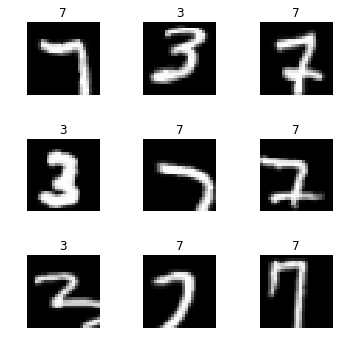

In [ ]:
data.show_batch(rows=3, figsize=(5,5))

In [ ]:
learn = create_cnn(data, models.resnet18, metrics=accuracy)
learn.fit(2)

Total time: 00:23
epoch  train_loss  valid_loss  accuracy
1      0.116117    0.029745    0.991168  (00:12)
2      0.056860    0.015974    0.994603  (00:10)



In [ ]:
df = pd.read_csv(path/'labels.csv')
df.head()

,name,label
0,train/3/7463.png,0
1,train/3/21102.png,0
2,train/3/31559.png,0
3,train/3/46882.png,0
4,train/3/26209.png,0


In [ ]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)

[0, 1]

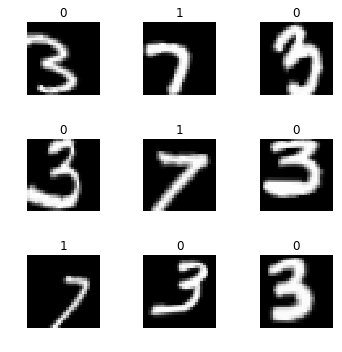

In [ ]:
data.show_batch(rows=3, figsize=(5,5))
data.classes

In [ ]:
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24)
data.classes

[0, 1]

In [ ]:
fn_paths = [path/name for name in df['name']]; fn_paths[:2]

[PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample/train/3/7463.png'),
 PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample/train/3/21102.png')]

In [ ]:
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24)
data.classes

['3', '7']

In [ ]:
data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7')
data.classes

['3', '7']

In [ ]:
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
labels[:5]

['3', '3', '3', '3', '3']

In [ ]:
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24)
data.classes

['3', '7']